In [ ]:
!pip install tensorflow numpy pandas scikit-learn
!pip install fuzzy-c-means
!pip install gensim
!pip install gdown

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
import gdown

data_id = "1sC01fTnf-sEX8A8Pva8_BXhCEIATkvvS"
url = f'https://drive.google.com/uc?id={data_id}'
output = './dataset.csv'  # Replace with the desired file name
gdown.download(url, output, quiet=False)

data = pd.read_csv('dataset.csv')

Downloading...
From: https://drive.google.com/uc?id=1sC01fTnf-sEX8A8Pva8_BXhCEIATkvvS
To: /content/dataset.csv
100%|██████████| 2.59M/2.59M [00:00<00:00, 84.0MB/s]


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1597 non-null   int64 
 1   userName           1597 non-null   object
 2   score              1597 non-null   int64 
 3   at                 1597 non-null   object
 4   content            1597 non-null   object
 5   casefolding        1597 non-null   object
 6   cleaning           1597 non-null   object
 7   Tokenize           1597 non-null   object
 8   normalisasi        1597 non-null   object
 9   stopwords removal  1597 non-null   object
 10  stemming           1597 non-null   object
 11  data_clean         1597 non-null   object
dtypes: int64(2), object(10)
memory usage: 149.8+ KB


In [49]:
data_sentiment = data[['score','data_clean']]
data_sentiment.loc[:,'score'] = data_sentiment.loc[:,'score'] - 1
data_sentiment['score']

0       0
1       2
2       2
3       1
4       2
       ..
1592    4
1593    0
1594    4
1595    3
1596    0
Name: score, Length: 1597, dtype: int64

In [50]:
train_data, test_data = train_test_split(data_sentiment, test_size=0.2, random_state=42)

In [51]:
# preprocess sentiment data
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# buld tokenier from train data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['data_clean'])

# make sequence from the tokenizer
train_sequences = tokenizer.texts_to_sequences(train_data['data_clean'])
test_sequences = tokenizer.texts_to_sequences(test_data['data_clean'])

# pad the sequence to max length
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')


In [ ]:
from gensim import corpora, models
import numpy as np

# preprocess for lda model data
texts = [text.split() for text in train_data['data_clean']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

np.random.seed(42)

# fit on lda model data
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=42)


In [56]:
# inspect the lda model data
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.030*"ramah" + 0.029*"aplikasi" + 0.025*"maxim" + 0.022*"driver"')
(1, '0.039*"driver" + 0.018*"maxim" + 0.017*"aplikasi" + 0.015*"pesan"')
(2, '0.036*"maxim" + 0.017*"order" + 0.017*"driver" + 0.014*"map"')
(3, '0.026*"titik" + 0.025*"driver" + 0.024*"maxim" + 0.021*"lokasi"')
(4, '0.028*"maxim" + 0.028*"driver" + 0.022*"order" + 0.022*"gak"')


In [53]:
from tensorflow.keras.utils import to_categorical

# one hot encode the sentiment analisys model
train_labels = to_categorical(train_data['score'], num_classes=5)
test_labels = to_categorical(test_data['score'], num_classes=5)

# sentiment analisys model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu',),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [54]:
# fit on sentiment analisys model
model.fit(train_padded, train_labels, batch_size=64, epochs=100, validation_data=(test_padded, test_labels))

Epoch 1/100
20/20 [==============================] - 1s 15ms/step - loss: 1.6019 - accuracy: 0.2529 - val_loss: 1.5878 - val_accuracy: 0.3344
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 1.5791 - accuracy: 0.3164 - val_loss: 1.5621 - val_accuracy: 0.4938
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 1.5553 - accuracy: 0.3485 - val_loss: 1.5364 - val_accuracy: 0.5531
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 1.5365 - accuracy: 0.3461 - val_loss: 1.5125 - val_accuracy: 0.5000
Epoch 5/100
20/20 [==============================] - 0s 11ms/step - loss: 1.5179 - accuracy: 0.3430 - val_loss: 1.4945 - val_accuracy: 0.3187
Epoch 6/100
20/20 [==============================] - 0s 12ms/step - loss: 1.5028 - accuracy: 0.3312 - val_loss: 1.4830 - val_accuracy: 0.3187
Epoch 7/100
20/20 [==============================] - 1s 33ms/step - loss: 1.5009 - accuracy: 0.3352 - val_loss: 1.4764 - val_accuracy: 0.3406
Epoch 8

In [57]:
# kano mapping based on lda model rules
kano_mapping = {
    0: 'attractive',  # Topic 0 interpreted as Attractive
    1: 'one_dimensional',  # Topic 1 interpreted as One-dimensional
    2: 'must_be',  # Topic 2 interpreted as Must-be
    3: 'indifferent',  # Topic 3 interpreted as Indifferent
    4: 'must_be'  # Topic 4 interpreted as Must-be
}

In [58]:
# evaluate text to get the kano model category
def evaluate_kano(text):
  # preprocess text
    text_processed = text.split()
    text_bow = dictionary.doc2bow(text_processed)

    # get lda model topics and return the category
    topic_distribution = lda_model.get_document_topics(text_bow)
    highest_topic = max(topic_distribution, key=lambda x: x[1])[0]
    kano_category = kano_mapping[highest_topic]

    return kano_category

# example use case
text_input = "driver maxim order ramah murah"
quality_rating = evaluate_kano(text_input)
print(f"Quality rating for the input: {quality_rating}")

Quality rating for the input: must_be


In [59]:
data['kano_category'] = data['data_clean'].apply(evaluate_kano)

In [62]:
# costumer mapping based kano category and sentiment score
costumer_mapping = {
    0: 'satisfied', # attractive high and one_dimensional high
    1: 'delighted', # must_be high and one dimensional middle high
    2: 'neutral', # indifferent medium high and one dimensioanl middle
    3: 'dissatisfied', # attractive low and indifferente middle low one dimensional middle low
    4: 'annoyed' # must be low and indifferent low and one dimensional low
}

In [63]:
# costumer segmentasetion based on rules
def costumer_segmentation(score, category):
  if score >= 3 and category == 'attractive':
    return costumer_mapping[0]
  elif score == 5 and category == 'one_dimensional':
    return costumer_mapping[0]
  elif score >= 3 and category == 'must_be':
    return costumer_mapping[1]
  elif score == 4 and category == 'one_dimensional':
    return costumer_mapping[1]
  elif score >= 4 and category == 'indifferent':
    return costumer_mapping[2]
  elif score == 3 and category == 'one_dimensional':
    return costumer_mapping[2]
  elif score <= 2 and category == 'attractive':
    return costumer_mapping[3]
  elif category == 'indifferent' and score == 3 or score == 2:
    return costumer_mapping[3]
  elif score == 2 and category == 'one_dimensional':
    return costumer_mapping[3]
  elif score <= 2 and category == 'must_be':
    return costumer_mapping[4]
  elif score == 1 and category in ['one_dimensional','indifferent']:
    return costumer_mapping[4]
  else:
    return 'Unknown'

In [64]:
data['costumer_segment'] = data.apply(lambda row: costumer_segmentation(row['score'], row['kano_category']), axis=1)

In [71]:
data.to_csv('./dataset_segment.csv')

In [74]:
# encode costumer score based on it segmentation
encode_customer = {
    'satisfied': 0,
    'delighted': 1,
    'neutral': 2,
    'dissatisfied': 3,
    'annoyed': 4
}

def encode_sentiment(sentiment):
    return encode_customer.get(sentiment, -1)

In [75]:
data['segment_score'] = data['costumer_segment'].apply(encode_sentiment)

In [81]:
# encode kano score based on it category
encode_kano = {
    'must_be': 0,
    'attractive': 1,
    'one_dimensional': 2,
    'indifferent': 3,
}

def encode_kano_score(category):
    return encode_kano.get(category, -1)

In [82]:
data['kano_score'] = data['kano_category'].apply(encode_kano_score)

In [84]:
column_select = ['content','score','kano_category','kano_score','costumer_segment','segment_score']
data_selected = data[column_select]
data_selected.head(10)

,content,score,kano_category,kano_score,costumer_segment,segment_score
0,Ada apa dengan Maxim. Padahal saya pesan Maxim...,1,indifferent,3,annoyed,4
1,Awal awal itu baik maka saya suka beri bintang...,3,must_be,0,delighted,1
2,titik lokasi masih banyak yg tidak sesuai deng...,3,indifferent,3,dissatisfied,3
3,"Pencarian alamat masih kurang efektif,banyak a...",2,indifferent,3,dissatisfied,3
4,"Tolong diperbaiki sistem map nya, masa kalah s...",3,indifferent,3,dissatisfied,3
5,Untuk yang lainnya tidak masalah ( saya penggu...,4,indifferent,3,neutral,2
6,"susah, ribet, alamat tidak jelas, mau ketik.al...",2,indifferent,3,dissatisfied,3
7,"Sekarang pelayanan tidak pernah ontime , drive...",1,indifferent,3,annoyed,4
8,Titik lokasinya tidak sesuai dengan lokasi pen...,1,indifferent,3,annoyed,4
9,kenapa maxim di kota sidoarjo tidak bisa beker...,3,must_be,0,delighted,1


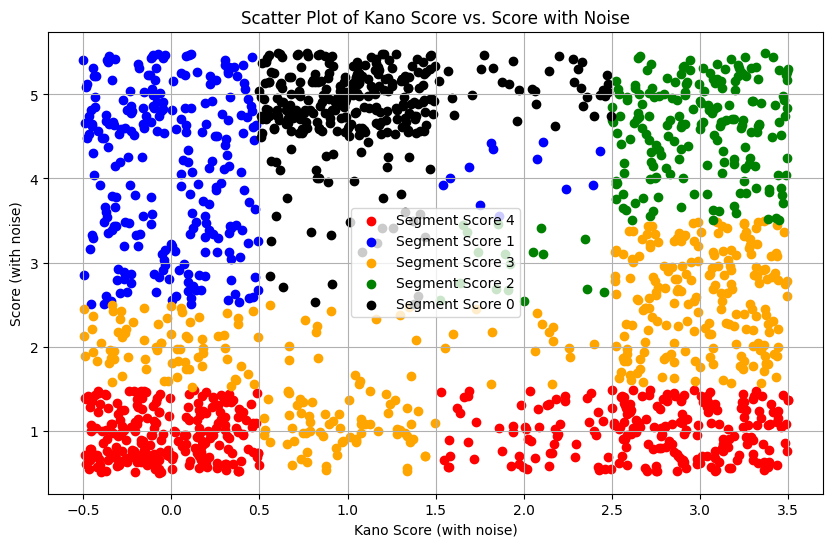

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def add_noise(x):
    noise = np.random.uniform(-0.5, 0.5)
    return x + noise

# apply noise
data['kano_score_noisy'] = data['kano_score'].apply(add_noise)
data['score_noisy'] = data['score'].apply(add_noise)

plt.figure(figsize=(10, 6))

colors = {0: 'black', 1: 'blue', 2: 'green', 3: 'orange', 4: 'red'}

# plot the graph
for segment_score in data['segment_score'].unique():
    subset = data[data['segment_score'] == segment_score]
    plt.scatter(subset['kano_score_noisy'], subset['score_noisy'], label=f'Segment Score {segment_score}', color=colors[segment_score])

plt.xlabel('Kano Score (with noise)')
plt.ylabel('Score (with noise)')
plt.title('Scatter Plot of Kano Score vs. Score with Noise')
plt.legend()
plt.grid(True)

plt.show()